In [1]:
# !unzip './content/Phase2.zip' './content/'

## Imports

In [2]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

In [3]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
NUM_CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4

In [4]:
base_dir = './content/DataSet2/Classification'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')
val_dir = os.path.join(base_dir, 'Validation')

In [5]:
train_noise_dir = os.path.join(train_dir, 'With-Noise')
train_denoise_dir = os.path.join(train_dir, 'Without-Noise')
test_noise_dir = os.path.join(test_dir, 'With-Noise')
test_denoise_dir = os.path.join(test_dir, 'Without-Noise')
val_noise_dir = os.path.join(val_dir, 'With-Noise')
val_denoise_dir = os.path.join(val_dir, 'Without-Noise')

In [6]:
def get_files_count(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [7]:
num_classes=len(glob.glob(train_dir+"/With-Noise/*"))

train_samples =get_files_count(train_dir)
test_samples=get_files_count(test_dir)
val_samples=get_files_count(val_dir)

print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")
print(val_samples,"Val images")

3 Classes
1814 Train images
380 Test images
324 Val images


**ImageDataGenerator**,Data augmentation is used to increase the size of training set. Through Data augmentation we want to prevent overfitting ,this refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating
* **Rescale:** One of the many magnification parameters adjusts the pixel values of our image.
* **Shear_range:** counterclockwise shear angle in degrees
* **Zoom_range:** zoom
* **Horizontal_flip:** flip image horizontally

In [8]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=40,
    fill_mode='nearest'
    )
test_datagen=ImageDataGenerator(rescale=1./255)

**flow_from_directory() -->** Another method to read images into TensorFlow environment is to use the .

**Parameters:**
* **directory:** The path of the target directory. It must contain one subdirectory per class. Any PNG, JPG, BMP or TIF formatted images found in each of the subdirectories will be included in the generator.
* **target_size:** A tuple of integers, (height, width), by default (256,256). All found images will be resized.
* **batch_size:** The size of the data chunks (default: 32).
* **shuffle:** Decides whether to shuffle data (default: True). If set to false, it sorts the data in alphanumeric order.



In [9]:
train_generator = train_datagen.flow_from_directory(
    train_noise_dir,
    # shuffle=True,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=32,
    )

test_generator = test_datagen.flow_from_directory(
    test_noise_dir,
    # shuffle=True,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=32,
    )

validation_generator = train_datagen.flow_from_directory(
    val_noise_dir,
    # shuffle=True,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=32,
    )

Found 904 images belonging to 3 classes.
Found 187 images belonging to 3 classes.
Found 159 images belonging to 3 classes.


In [10]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), weights))
class_weights

{0: 1.0426758938869665, 1: 0.9243353783231084, 2: 1.0426758938869665}

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks for early stopping, model checkpointing, and learning rate reduction
my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

## VGG16

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy



# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze pre-trained layers for fine-tuning later
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.25)(x)
# x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create full model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing for regularization
    optimizer=Adam(learning_rate=LEARNING_RATE),  # Reduced learning rate from 2e-4
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# Train the model on the combined training data (all noise types)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights,
    callbacks=my_callbacks
)

Epoch 1/10
29/29 [==============================] - 35s 739ms/step - loss: 0.7863 - accuracy: 0.7002 - val_loss: 0.4755 - val_accuracy: 0.9748 - lr: 1.0000e-04
Epoch 2/10
29/29 [==============================] - 10s 339ms/step - loss: 0.4319 - accuracy: 0.9580 - val_loss: 0.3774 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/10
29/29 [==============================] - 10s 341ms/step - loss: 0.3697 - accuracy: 0.9867 - val_loss: 0.3568 - val_accuracy: 0.9874 - lr: 1.0000e-04
Epoch 4/10
29/29 [==============================] - 10s 338ms/step - loss: 0.3548 - accuracy: 0.9945 - val_loss: 0.3392 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 5/10
29/29 [==============================] - 10s 328ms/step - loss: 0.3456 - accuracy: 0.9945 - val_loss: 0.3295 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 6/10
29/29 [==============================] - 10s 327ms/step - loss: 0.3408 - accuracy: 0.9989 - val_loss: 0.3336 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 7/10
29/29 [======================

In [14]:
predict = []
for x in model.predict(test_generator):
    predict.append(np.argmax(x))
predict = np.int8(predict)

6/6 [==============================] - 9s 2s/step


In [15]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predict))

              precision    recall  f1-score   support

           0       0.32      0.32      0.32        60
           1       0.39      0.39      0.39        67
           2       0.32      0.32      0.32        60

    accuracy                           0.34       187
   macro avg       0.34      0.34      0.34       187
weighted avg       0.34      0.34      0.34       187



In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
5/5 [==============================] - 2s 269ms/step - loss: 0.3210 - accuracy: 0.9937
Test Accuracy: 99.37106966972351


In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 2s 237ms/step - loss: 0.3420 - accuracy: 1.0000
Test Accuracy: 100.0


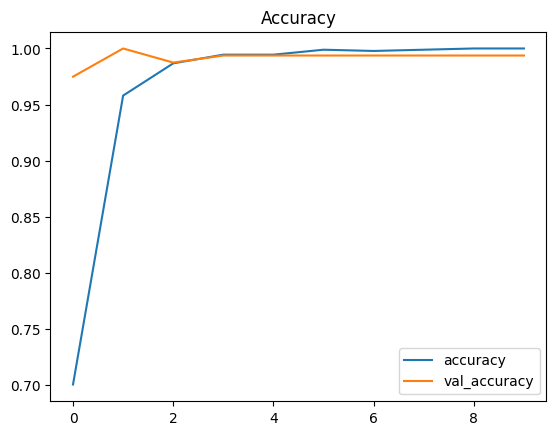

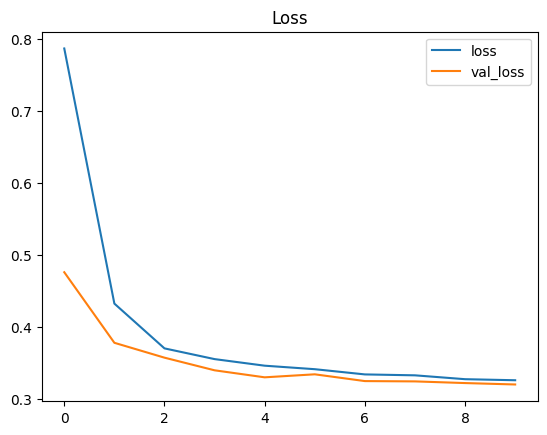

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
# model.save('./content/models/VGG16_Spatial_Classification.h5')

## Inception ResNet V2

In [20]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

pretrained_model = InceptionResNetV2(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [21]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

x = pretrained_model.output
x = Flatten()(x)
x = Dropout(0.25)(x)  # Regularization
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=pretrained_model.input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [22]:
model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights,
    callbacks=my_callbacks
)

Epoch 1/10
29/29 [==============================] - 26s 551ms/step - loss: 1.3591 - accuracy: 0.3938 - val_loss: 0.9677 - val_accuracy: 0.5220 - lr: 1.0000e-04
Epoch 2/10
29/29 [==============================] - 10s 340ms/step - loss: 0.9565 - accuracy: 0.5808 - val_loss: 0.6505 - val_accuracy: 0.8868 - lr: 1.0000e-04
Epoch 3/10
29/29 [==============================] - 10s 340ms/step - loss: 0.7201 - accuracy: 0.7666 - val_loss: 0.5064 - val_accuracy: 0.9748 - lr: 1.0000e-04
Epoch 4/10
29/29 [==============================] - 10s 342ms/step - loss: 0.5921 - accuracy: 0.8507 - val_loss: 0.4424 - val_accuracy: 0.9811 - lr: 1.0000e-04
Epoch 5/10
29/29 [==============================] - 10s 344ms/step - loss: 0.5346 - accuracy: 0.8960 - val_loss: 0.3993 - val_accuracy: 0.9874 - lr: 1.0000e-04
Epoch 6/10
29/29 [==============================] - 10s 334ms/step - loss: 0.4657 - accuracy: 0.9325 - val_loss: 0.3546 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 7/10
29/29 [======================

In [24]:
# model.save('./content/models/InceptionResNetV2_Spatial_Classification.h5')

In [25]:
predict = np.int8(np.argmax(model.predict(test_generator), axis=1))

6/6 [==============================] - 6s 689ms/step


In [26]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, predict))

              precision    recall  f1-score   support

           0       0.29      0.28      0.29        60
           1       0.32      0.33      0.32        67
           2       0.22      0.22      0.22        60

    accuracy                           0.28       187
   macro avg       0.28      0.28      0.28       187
weighted avg       0.28      0.28      0.28       187



In [27]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
5/5 [==============================] - 2s 275ms/step - loss: 0.3343 - accuracy: 1.0000
Test Accuracy: 100.0


In [28]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 2s 265ms/step - loss: 0.3508 - accuracy: 0.9893
Test Accuracy: 98.93048405647278


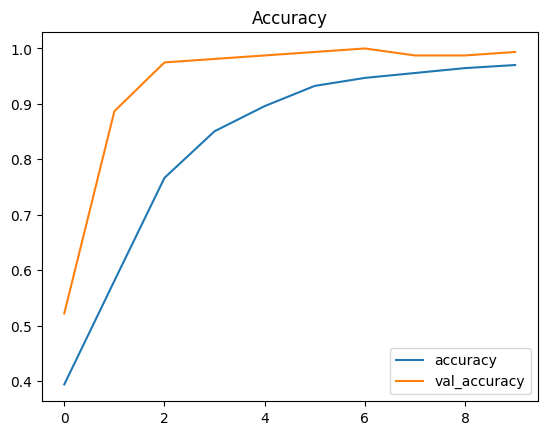

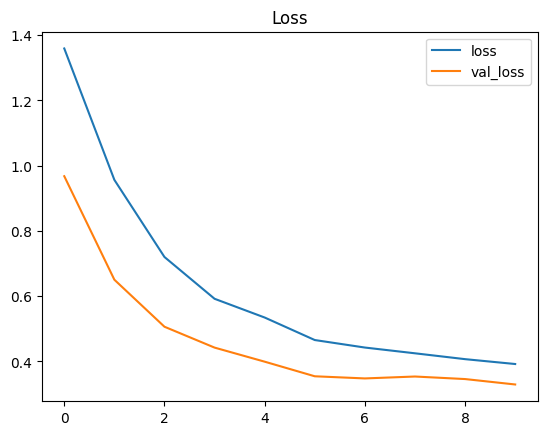

In [29]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

1/1 [==============================] - 4s 4s/step
Periodic


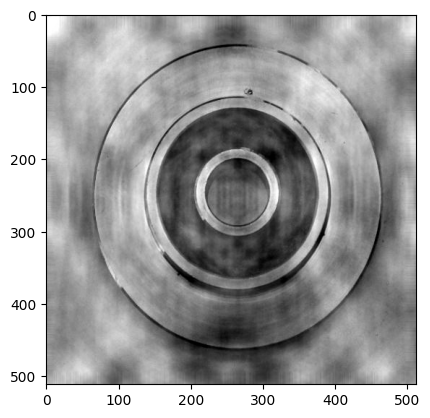

In [30]:
import keras.utils as image

classes=list(train_generator.class_indices.keys())
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='./content/DataSet2/Classification/Train/With-Noise/Periodic/cast_def_0_3185.jpeg'
result = model.predict([prepare(img_url)])
casting_img=image.load_img(img_url)
plt.imshow(casting_img)

classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

In [32]:
print(test_generator.classes)
print(predict)
print(test_generator.class_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[2 0 2 0 0 2 0 0 1 2 2 2 2 2 2 1 2 2 2 2 0 1 1 2 1 2 2 1 2 2 1 1 2 0 1 0 0
 0 0 0 0 2 2 1 0 1 2 0 1 1 1 1 2 1 1 0 2 1 2 0 1 2 1 1 2 1 1 1 1 2 1 0 0 1
 0 2 0 0 0 2 0 0 1 0 2 2 0 1 1 2 2 0 0 2 0 1 1 2 2 2 1 2 1 1 2 0 2 1 0 0 2
 0 0 1 0 0 1 0 1 2 0 0 2 2 2 1 0 1 1 1 2 2 0 1 0 1 1 1 2 2 1 0 2 1 0 0 1 2
 2 0 2 0 0 0 1 2 0 1 0 1 1 0 0 1 2 1 0 1 2 1 2 1 1 0 1 1 1 2 1 1 1 1 1 0 0
 1 0]
{'Gaussian': 0, 'Periodic': 1, 'Salt': 2}
